<a href="https://colab.research.google.com/github/nrysam/sentiment_yelp/blob/main/Sentiment_Analysis_Yelp_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# Get the dataset
!gdown --id 1N3S_QJi6511IG3VHDH3sewcqke8vt8kc

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1N3S_QJi6511IG3VHDH3sewcqke8vt8kc
From (redirected): https://drive.google.com/uc?id=1N3S_QJi6511IG3VHDH3sewcqke8vt8kc&confirm=t&uuid=3fe0056a-63a9-4729-910a-263ccb0ffd07
To: /content/yelp_review_fine-grained_5_classes_csv.zip
100% 201M/201M [00:08<00:00, 23.8MB/s]


In [3]:
# Unzip the dataset
!unzip -q 'yelp_review_fine-grained_5_classes_csv.zip' -d dataset

In [4]:
# Load the datasets
train_data = pd.read_csv('./dataset/yelp_review_fine-grained_5_classes_csv/train.csv')
test_data = pd.read_csv('./dataset/yelp_review_fine-grained_5_classes_csv/test.csv')

# Prepare the labels
train_data['Sentiment'] = train_data['class_index'].apply(lambda x: 1 if x > 3 else 0)
test_data['Sentiment'] = test_data['class_index'].apply(lambda x: 1 if x > 3 else 0)

# Split data
x_train, y_train = train_data['review_text'], train_data['Sentiment']
x_test, y_test = test_data['review_text'], test_data['Sentiment']

In [5]:
NUM_WORDS = 5000
EMBEDDING_DIM = 8
MAXLEN = 100
PADDING = 'post'
OOV_TOKEN = "<OOV>"

In [6]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [8]:
# Test your function
tokenizer = fit_tokenizer(x_train, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 270679 words

<OOV> token included in vocabulary


In [7]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    return padded_sequences

In [9]:
train_padded_seq = seq_and_pad(x_train, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(x_test, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (650000, 100)

Padded validation sequences have shape: (50000, 100)


In [10]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [11]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, y_train, epochs=10, batch_size=128, validation_data=(val_padded_seq, y_test))

Epoch 1/10
5079/5079 [==============================] - 899s 175ms/step - loss: 0.3515 - accuracy: 0.8491 - val_loss: 0.3075 - val_accuracy: 0.8632
Epoch 2/10
5079/5079 [==============================] - 881s 174ms/step - loss: 0.3052 - accuracy: 0.8716 - val_loss: 0.2818 - val_accuracy: 0.8772
Epoch 3/10
5079/5079 [==============================] - 872s 172ms/step - loss: 0.2830 - accuracy: 0.8818 - val_loss: 0.2811 - val_accuracy: 0.8786
Epoch 4/10
5079/5079 [==============================] - 876s 172ms/step - loss: 0.2735 - accuracy: 0.8859 - val_loss: 0.2702 - val_accuracy: 0.8814
Epoch 5/10
5079/5079 [==============================] - 864s 170ms/step - loss: 0.2672 - accuracy: 0.8888 - val_loss: 0.2694 - val_accuracy: 0.8829
Epoch 6/10
5079/5079 [==============================] - 861s 170ms/step - loss: 0.2623 - accuracy: 0.8908 - val_loss: 0.2714 - val_accuracy: 0.8820
Epoch 7/10
5079/5079 [==============================] - 859s 169ms/step - loss: 0.2587 - accuracy: 0.8928 - val_

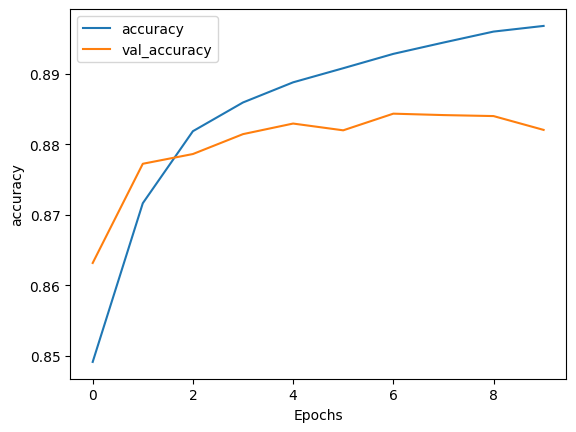

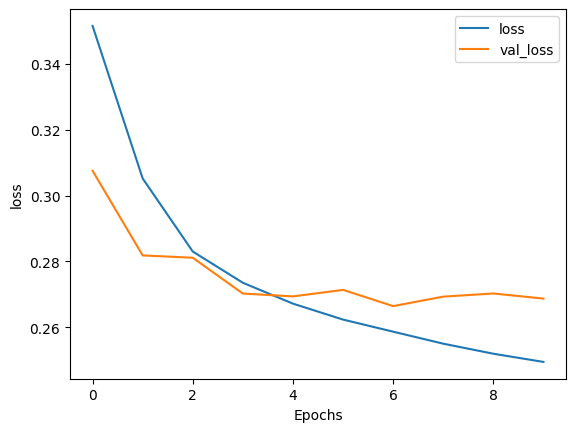

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
def predict_sentiment(review, tokenizer, model, padding, maxlen):
    """
    Predicts the sentiment of a review.

    Args:
    review (str): The review text.
    tokenizer (Tokenizer): Tokenizer object used for training the model.
    model (tf.keras Model): Trained model.
    padding (str): Padding type for sequences (default 'post').
    maxlen (int): Maximum length of the sequence (default 100).

    Returns:
    str: 'Positive' or 'Negative' indicating the review sentiment.
    """
    # Tokenize and pad the review
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen, padding=padding)

    # Predict the sentiment
    prediction = model.predict(padded_sequence)[0][0]

    # Determine sentiment
    sentiment = "Positive" if prediction > 0.5 else "Negative"

    # Print sentiment and prediction probability
    print(f"The sentiment is {sentiment} with with a sentiment value of {prediction:.2f}.")
    return sentiment, prediction

In [33]:
# Example usage:
sample_review1 = "The food was great and the service was excellent!"
sample_review2 = "Terrible experience. The food was bland and overpriced. The waiters ignored us for 20 minutes. Not recommended."
sample_review3 = "It was quite a surprise! Initially seemed a bit pricey, but the flavors and the presentation were beyond expectations."
sample_review4 = "The location was great, but the food didn't live up to the hype. The dishes were somewhat underwhelming, given the rave reviews."
sample_review5 = "The dessert was phenomenal, a true masterpiece! However, the main course was just average and not what I expected from a highly-rated restaurant."

predict_sentiment(sample_review1, tokenizer, model, PADDING, MAXLEN)
predict_sentiment(sample_review2, tokenizer, model, PADDING, MAXLEN)
predict_sentiment(sample_review3, tokenizer, model, PADDING, MAXLEN)
predict_sentiment(sample_review4, tokenizer, model, PADDING, MAXLEN)
predict_sentiment(sample_review5, tokenizer, model, PADDING, MAXLEN)

1/1 [==============================] - 0s 33ms/step
The sentiment is Positive with with a sentiment value of 0.94.
1/1 [==============================] - 0s 32ms/step
The sentiment is Negative with with a sentiment value of 0.00.
1/1 [==============================] - 0s 35ms/step
The sentiment is Positive with with a sentiment value of 0.51.
1/1 [==============================] - 0s 33ms/step
The sentiment is Negative with with a sentiment value of 0.00.
1/1 [==============================] - 0s 37ms/step
The sentiment is Negative with with a sentiment value of 0.05.


('Negative', 0.04522979)